# Data Transformation Notebook
## Steel Industry Load Type Prediction

This notebook handles the data transformation phase of our ML pipeline.

**Objectives:**
- Load the validated data
- Perform feature engineering
- Handle categorical encoding
- Apply feature scaling/normalization
- Create derived features
- Save the transformed data for model training

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Data Transformation Phase Started")
print(f"Timestamp: {datetime.now()}")

Data Transformation Phase Started
Timestamp: 2025-10-19 11:28:28.862322


## 1. Load Validated Data

In [2]:
# Load the validated data
input_filename = 'validated_data.csv'

try:
    df = pd.read_csv(input_filename)
    print(f"✓ Data loaded successfully from {input_filename}")
    print(f"Dataset shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
except FileNotFoundError:
    print(f"❌ Error: {input_filename} not found. Please run 02_data_validation.ipynb first.")
    raise
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

✓ Data loaded successfully from validated_data.csv
Dataset shape: (35040, 16)
Memory usage: 11.22 MB


In [3]:
# Quick overview of loaded data
print("=== LOADED DATA OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget distribution:")
print(df['Load_Type'].value_counts())
print(f"\nBasic info:")
df.info()

=== LOADED DATA OVERVIEW ===
Shape: (35040, 16)

Columns: ['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'year', 'month', 'day', 'hour', 'minute']

Target distribution:
Load_Type
Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)          

## 2. Feature Engineering

In [4]:
# Create a copy for transformation
df_transformed = df.copy()

print("=== FEATURE ENGINEERING ===")

# 1. Date/Time Feature Engineering
if 'date' in df_transformed.columns:
    # Convert to datetime if not already
    if df_transformed['date'].dtype == 'object':
        df_transformed['date'] = pd.to_datetime(df_transformed['date'])
    
    # Extract time-based features (if not already present)
    if 'year' not in df_transformed.columns:
        df_transformed['year'] = df_transformed['date'].dt.year
    if 'month' not in df_transformed.columns:
        df_transformed['month'] = df_transformed['date'].dt.month
    if 'day' not in df_transformed.columns:
        df_transformed['day'] = df_transformed['date'].dt.day
    if 'hour' not in df_transformed.columns:
        df_transformed['hour'] = df_transformed['date'].dt.hour
    if 'minute' not in df_transformed.columns:
        df_transformed['minute'] = df_transformed['date'].dt.minute
    
    # Additional time features
    df_transformed['day_of_year'] = df_transformed['date'].dt.dayofyear
    df_transformed['week_of_year'] = df_transformed['date'].dt.isocalendar().week
    df_transformed['quarter'] = df_transformed['date'].dt.quarter
    
    # Cyclical encoding for time features
    df_transformed['hour_sin'] = np.sin(2 * np.pi * df_transformed['hour'] / 24)
    df_transformed['hour_cos'] = np.cos(2 * np.pi * df_transformed['hour'] / 24)
    df_transformed['month_sin'] = np.sin(2 * np.pi * df_transformed['month'] / 12)
    df_transformed['month_cos'] = np.cos(2 * np.pi * df_transformed['month'] / 12)
    
    print("✓ Time-based features engineered")

# 2. Power-related Feature Engineering
if all(col in df_transformed.columns for col in ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh']):
    # Total reactive power
    df_transformed['Total_Reactive_Power'] = (
        df_transformed['Lagging_Current_Reactive.Power_kVarh'] + 
        df_transformed['Leading_Current_Reactive_Power_kVarh']
    )
    
    # Power factor difference
    if all(col in df_transformed.columns for col in ['Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']):
        df_transformed['Power_Factor_Difference'] = (
            df_transformed['Leading_Current_Power_Factor'] - 
            df_transformed['Lagging_Current_Power_Factor']
        )
    
    # Power efficiency ratio
    df_transformed['Power_Efficiency'] = df_transformed['Usage_kWh'] / (
        df_transformed['Total_Reactive_Power'] + 1  # Add 1 to avoid division by zero
    )
    
    print("✓ Power-related features engineered")

# 3. Usage intensity categories
if 'Usage_kWh' in df_transformed.columns:
    # Create usage intensity bins
    usage_percentiles = df_transformed['Usage_kWh'].quantile([0.25, 0.5, 0.75])
    df_transformed['Usage_Intensity'] = pd.cut(
        df_transformed['Usage_kWh'],
        bins=[-np.inf, usage_percentiles[0.25], usage_percentiles[0.5], usage_percentiles[0.75], np.inf],
        labels=['Very_Low', 'Low', 'Medium', 'High']
    )
    
    print("✓ Usage intensity categories created")

# 4. Statistical features (rolling/lag features - simplified for time series)
if 'Usage_kWh' in df_transformed.columns and 'date' in df_transformed.columns:
    # Sort by date for time series operations
    df_transformed = df_transformed.sort_values('date')
    
    # Create lag features (previous values)
    df_transformed['Usage_kWh_lag1'] = df_transformed['Usage_kWh'].shift(1)
    df_transformed['Usage_kWh_lag2'] = df_transformed['Usage_kWh'].shift(2)
    
    # Rolling statistics
    df_transformed['Usage_kWh_rolling_mean_3'] = df_transformed['Usage_kWh'].rolling(window=3).mean()
    df_transformed['Usage_kWh_rolling_std_3'] = df_transformed['Usage_kWh'].rolling(window=3).std()
    
    print("✓ Time series features created")

print(f"\nFeatures after engineering: {df_transformed.shape[1]}")
print(f"New features added: {df_transformed.shape[1] - df.shape[1]}")

=== FEATURE ENGINEERING ===
✓ Time-based features engineered
✓ Power-related features engineered
✓ Usage intensity categories created
✓ Time series features created

Features after engineering: 31
New features added: 15


## 3. Handle Missing Values from Feature Engineering

In [5]:
# Check for missing values created during feature engineering
print("=== HANDLING MISSING VALUES FROM FEATURE ENGINEERING ===")

missing_after_engineering = df_transformed.isnull().sum()
missing_cols = missing_after_engineering[missing_after_engineering > 0]

if len(missing_cols) > 0:
    print("Missing values after feature engineering:")
    for col, count in missing_cols.items():
        print(f"  {col}: {count} ({count/len(df_transformed)*100:.2f}%)")
    
    # Handle missing values
    for col in missing_cols.index:
        if col.startswith('Usage_kWh_lag') or col.startswith('Usage_kWh_rolling'):
            # For lag and rolling features, forward fill then backward fill
            df_transformed[col] = df_transformed[col].fillna(method='ffill').fillna(method='bfill')
            print(f"  ✓ Filled missing values in {col}")
        elif col in ['Usage_Intensity']:
            # For categorical features, fill with mode
            mode_value = df_transformed[col].mode()[0] if not df_transformed[col].mode().empty else 'Unknown'
            df_transformed[col] = df_transformed[col].fillna(mode_value)
            print(f"  ✓ Filled missing values in {col} with mode: {mode_value}")
        else:
            # For other numerical features, fill with median
            median_value = df_transformed[col].median()
            df_transformed[col] = df_transformed[col].fillna(median_value)
            print(f"  ✓ Filled missing values in {col} with median: {median_value:.2f}")
else:
    print("✓ No missing values created during feature engineering")

# Verify no missing values remain
final_missing = df_transformed.isnull().sum().sum()
print(f"\nFinal missing values count: {final_missing}")

=== HANDLING MISSING VALUES FROM FEATURE ENGINEERING ===
Missing values after feature engineering:
  Usage_kWh_lag1: 1 (0.00%)
  Usage_kWh_lag2: 2 (0.01%)
  Usage_kWh_rolling_mean_3: 2 (0.01%)
  Usage_kWh_rolling_std_3: 2 (0.01%)
  ✓ Filled missing values in Usage_kWh_lag1
  ✓ Filled missing values in Usage_kWh_lag2
  ✓ Filled missing values in Usage_kWh_rolling_mean_3
  ✓ Filled missing values in Usage_kWh_rolling_std_3

Final missing values count: 0


## 4. Feature Selection and Dimensionality Assessment

In [6]:
# Prepare data for feature selection
print("=== FEATURE SELECTION AND ANALYSIS ===")

# Separate features and target
target_col = 'Load_Type'
exclude_cols = ['date', target_col]  # Columns to exclude from features
feature_cols = [col for col in df_transformed.columns if col not in exclude_cols]

print(f"Total features available: {len(feature_cols)}")
print(f"Target variable: {target_col}")

# Separate numerical and categorical features
numerical_features = df_transformed[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_transformed[feature_cols].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

print(f"\nNumerical features: {numerical_features}")
print(f"\nCategorical features: {categorical_features}")

=== FEATURE SELECTION AND ANALYSIS ===
Total features available: 29
Target variable: Load_Type

Numerical features: 26
Categorical features: 3

Numerical features: ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'year', 'month', 'day', 'hour', 'minute', 'day_of_year', 'week_of_year', 'quarter', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'Total_Reactive_Power', 'Power_Factor_Difference', 'Power_Efficiency', 'Usage_kWh_lag1', 'Usage_kWh_lag2', 'Usage_kWh_rolling_mean_3', 'Usage_kWh_rolling_std_3']

Categorical features: ['WeekStatus', 'Day_of_week', 'Usage_Intensity']


## 5. Categorical Encoding

In [7]:
# Handle categorical encoding
print("=== CATEGORICAL ENCODING ===")

# Initialize encoders dictionary to save for later use
encoders = {}

# Handle target variable encoding
label_encoder = LabelEncoder()
df_transformed['Load_Type_encoded'] = label_encoder.fit_transform(df_transformed[target_col])
encoders['target_encoder'] = label_encoder

print(f"Target encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Handle categorical features
for col in categorical_features:
    unique_values = df_transformed[col].nunique()
    print(f"\nProcessing {col}: {unique_values} unique values")

    if unique_values == 2:
        # Binary encoding for binary categorical variables
        le = LabelEncoder()
        df_transformed[f'{col}_encoded'] = le.fit_transform(df_transformed[col])
        encoders[col] = le
        print(f"  ✓ Binary encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}")

    elif unique_values <= 10:
        # One-hot encoding for low cardinality categorical variables
        dummies = pd.get_dummies(df_transformed[col], prefix=col, drop_first=True)
        df_transformed = pd.concat([df_transformed, dummies], axis=1)
        encoders[col] = f"one_hot_encoded_with_prefix_{col}"
        print(f"  ✓ One-hot encoded: {len(dummies.columns)} new columns created")

    else:
        # Label encoding for high cardinality categorical variables
        le = LabelEncoder()
        df_transformed[f'{col}_encoded'] = le.fit_transform(df_transformed[col])
        encoders[col] = le
        print(f"  ✓ Label encoded: {unique_values} categories")

# Remove original categorical columns (keep the original target for reference)
categorical_to_remove = [col for col in categorical_features]
df_transformed = df_transformed.drop(columns=categorical_to_remove)

print(f"\n✓ Categorical encoding completed")
print(f"Shape after encoding: {df_transformed.shape}")

# Save encoders
joblib.dump(encoders, 'encoders.pkl')
print("✓ Encoders saved to encoders.pkl")

=== CATEGORICAL ENCODING ===
Target encoding: {'Light_Load': np.int64(0), 'Maximum_Load': np.int64(1), 'Medium_Load': np.int64(2)}

Processing WeekStatus: 2 unique values
  ✓ Binary encoded: {'Weekday': np.int64(0), 'Weekend': np.int64(1)}

Processing Day_of_week: 7 unique values
  ✓ One-hot encoded: 6 new columns created

Processing Usage_Intensity: 4 unique values
  ✓ One-hot encoded: 3 new columns created

✓ Categorical encoding completed
Shape after encoding: (35040, 39)
✓ Encoders saved to encoders.pkl


## 6. Feature Scaling and Normalization

In [8]:
# Apply feature scaling
print("=== FEATURE SCALING AND NORMALIZATION ===")

# Separate features and target
exclude_for_scaling = ['date', 'Load_Type_encoded']  # Don't scale target and date
features_to_scale = [col for col in df_transformed.columns if col not in exclude_for_scaling]

print(f"Features to scale: {len(features_to_scale)}")

# Create a copy for different scaling methods comparison
df_standard = df_transformed.copy()
df_minmax = df_transformed.copy()
df_robust = df_transformed.copy()

# Initialize scalers
scalers = {}
numeric_cols = df_standard[features_to_scale].select_dtypes(include='number').columns

# 1. StandardScaler (Z-score normalization)
standard_scaler = StandardScaler()
df_standard[numeric_cols] = standard_scaler.fit_transform(df_standard[numeric_cols])
scalers['standard_scaler'] = standard_scaler
print("✓ StandardScaler applied")

# 2. MinMaxScaler (0-1 scaling)
minmax_scaler = MinMaxScaler()
df_minmax[numeric_cols] = minmax_scaler.fit_transform(df_minmax[numeric_cols])
# df_minmax[features_to_scale] = minmax_scaler.fit_transform(df_minmax[features_to_scale])
scalers['minmax_scaler'] = minmax_scaler
print("✓ MinMaxScaler applied")

# 3. RobustScaler (using median and IQR) - for data with outliers
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
df_robust[numeric_cols] = robust_scaler.fit_transform(df_robust[numeric_cols])
# df_robust[features_to_scale] = robust_scaler.fit_transform(df_robust[features_to_scale])
scalers['robust_scaler'] = robust_scaler
print("✓ RobustScaler applied")

# For this implementation, we'll use StandardScaler as default
df_scaled = df_standard.copy()
chosen_scaler = 'standard_scaler'

print(f"\n✓ Using {chosen_scaler} for final dataset")
print(f"Scaled dataset shape: {df_scaled.shape}")

# Save the chosen scaler
joblib.dump(scalers[chosen_scaler], f'{chosen_scaler}.pkl')
joblib.dump(scalers, 'all_scalers.pkl')
print(f"✓ Scalers saved")

=== FEATURE SCALING AND NORMALIZATION ===
Features to scale: 37
✓ StandardScaler applied
✓ MinMaxScaler applied
✓ RobustScaler applied

✓ Using standard_scaler for final dataset
Scaled dataset shape: (35040, 39)
✓ Scalers saved


## 7. Data Distribution Analysis After Transformation

=== DATA DISTRIBUTION ANALYSIS AFTER TRANSFORMATION ===


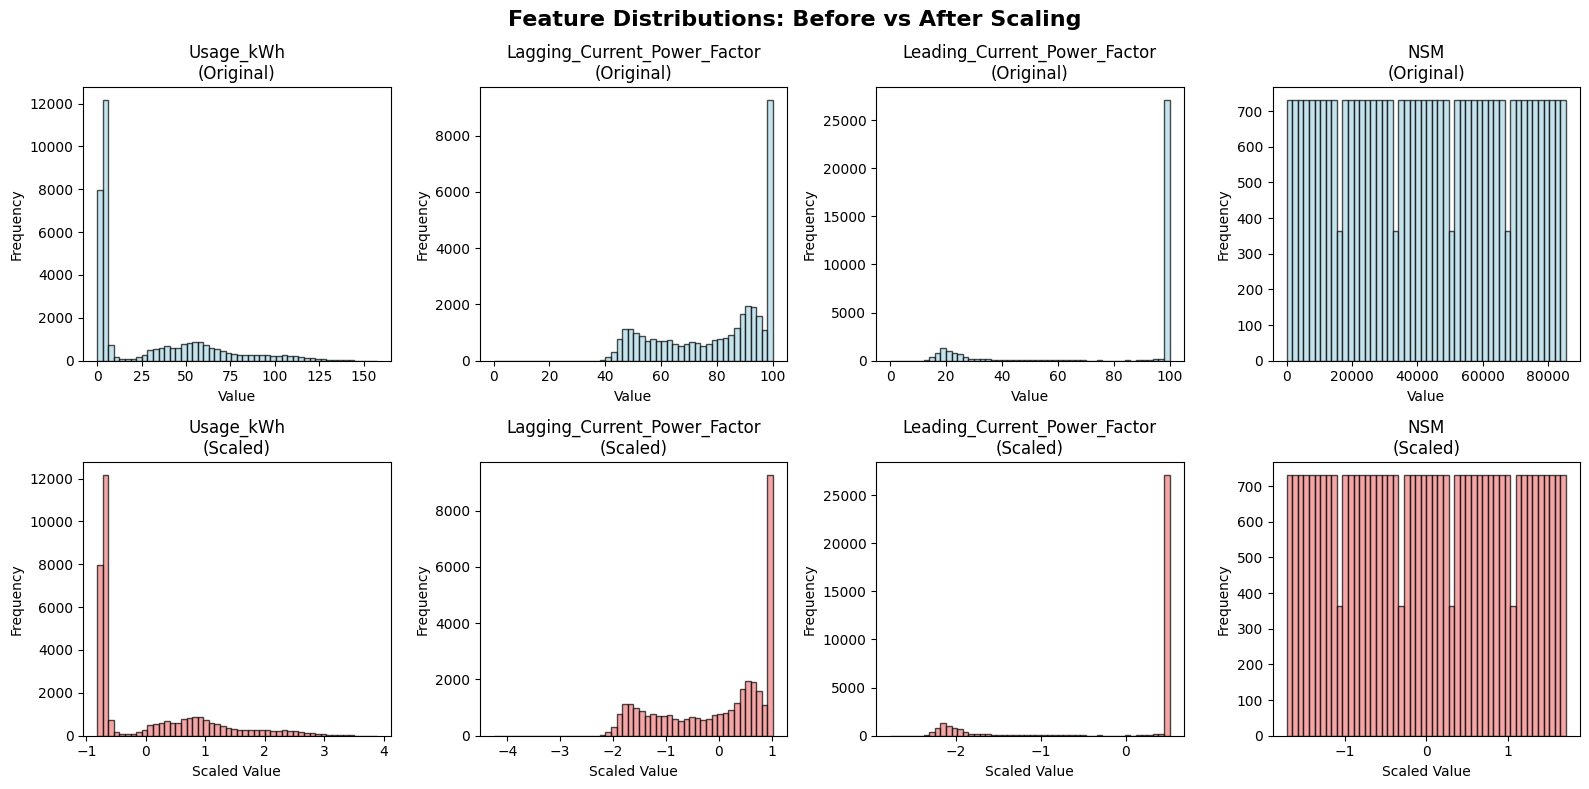


Statistics of scaled features (first 5 columns):
          Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
count  3.504000e+04                          3.504000e+04   
mean  -1.168015e-16                          7.218984e-17   
std    1.000014e+00                          1.000014e+00   
min   -8.188905e-01                         -7.994339e-01   
25%   -7.232078e-01                         -6.583795e-01   
50%   -6.822437e-01                         -4.927940e-01   
75%    7.131526e-01                          5.890319e-01   
max    3.880920e+00                          5.143862e+00   

       Leading_Current_Reactive_Power_kVarh     CO2(tCO2)  \
count                          3.504000e+04  3.504000e+04   
mean                           1.038236e-16 -1.816913e-16   
std                            1.000014e+00  1.000014e+00   
min                           -5.213850e-01 -7.135502e-01   
25%                           -5.213850e-01 -7.135502e-01   
50%                           -5.2

In [9]:
# Analyze data distribution after transformation
print("=== DATA DISTRIBUTION ANALYSIS AFTER TRANSFORMATION ===")

# Select a few key features for visualization
key_features = ['Usage_kWh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
key_features = [col for col in key_features if col in df_scaled.columns]

if len(key_features) > 0:
    fig, axes = plt.subplots(2, len(key_features), figsize=(4*len(key_features), 8))
    
    for i, feature in enumerate(key_features):
        # Original distribution
        axes[0, i].hist(df[feature], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
        axes[0, i].set_title(f'{feature}\n(Original)')
        axes[0, i].set_xlabel('Value')
        axes[0, i].set_ylabel('Frequency')
        
        # Transformed distribution
        axes[1, i].hist(df_scaled[feature], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1, i].set_title(f'{feature}\n(Scaled)')
        axes[1, i].set_xlabel('Scaled Value')
        axes[1, i].set_ylabel('Frequency')
    
    plt.suptitle('Feature Distributions: Before vs After Scaling', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Key features not found for distribution analysis")

# Show basic statistics of scaled features
scaled_features_stats = df_scaled[features_to_scale].describe()
print("\nStatistics of scaled features (first 5 columns):")
print(scaled_features_stats.iloc[:, :5])

## 8. Feature Importance Analysis

=== FEATURE IMPORTANCE ANALYSIS ===
Features for importance analysis: 27
Samples: 35040

Top 10 features by F-score:
                         Feature       F_Score  P_Value
24      Usage_kWh_rolling_mean_3  13580.741817      0.0
23                Usage_kWh_lag2  13195.841320      0.0
22                Usage_kWh_lag1  11910.492674      0.0
0                      Usage_kWh  10787.797531      0.0
3                      CO2(tCO2)  10544.816826      0.0
10                          hour  10228.339018      0.0
6                            NSM  10201.993602      0.0
15                      hour_sin   9967.904267      0.0
4   Lagging_Current_Power_Factor   9631.678478      0.0
19          Total_Reactive_Power   5876.183266      0.0

Top 10 features by Mutual Information:
                         Feature  MI_Score
6                            NSM  0.585289
10                          hour  0.502573
21              Power_Efficiency  0.404939
20       Power_Factor_Difference  0.402573
23          

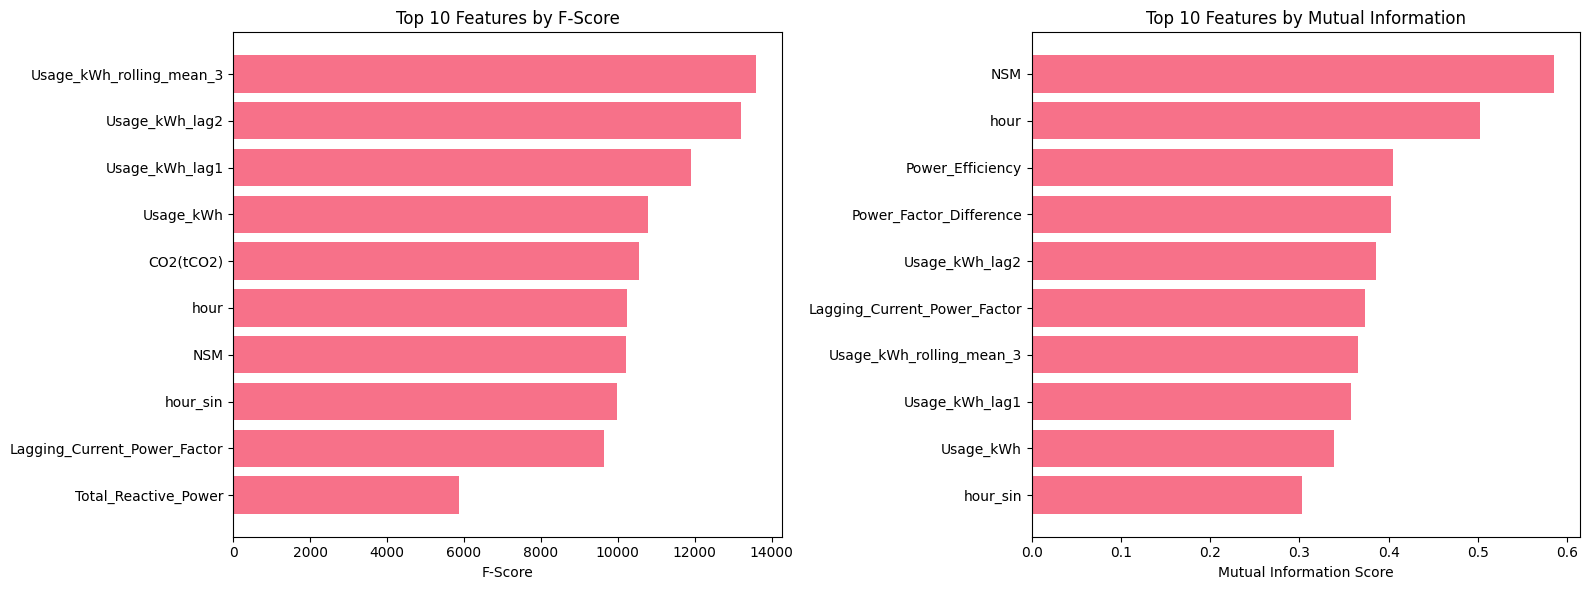


✓ Feature importance analysis completed


In [10]:
# Analyze feature importance
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Prepare features and target for analysis
X = df_scaled[numeric_cols]
y = df_scaled['Load_Type_encoded']

print(f"Features for importance analysis: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# 1. Univariate feature selection using f_classif
selector_f = SelectKBest(score_func=f_classif, k='all')
selector_f.fit(X, y)

# Get feature scores
feature_scores_f = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
}).sort_values('F_Score', ascending=False)

print("\nTop 10 features by F-score:")
print(feature_scores_f.head(10))

# 2. Mutual information based feature selection
mi_scores = mutual_info_classif(X, y, random_state=42)
feature_scores_mi = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nTop 10 features by Mutual Information:")
print(feature_scores_mi.head(10))

# Visualize top features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# F-score plot
top_f_features = feature_scores_f.head(10)
ax1.barh(range(len(top_f_features)), top_f_features['F_Score'])
ax1.set_yticks(range(len(top_f_features)))
ax1.set_yticklabels(top_f_features['Feature'])
ax1.set_xlabel('F-Score')
ax1.set_title('Top 10 Features by F-Score')
ax1.invert_yaxis()

# MI score plot
top_mi_features = feature_scores_mi.head(10)
ax2.barh(range(len(top_mi_features)), top_mi_features['MI_Score'])
ax2.set_yticks(range(len(top_mi_features)))
ax2.set_yticklabels(top_mi_features['Feature'])
ax2.set_xlabel('Mutual Information Score')
ax2.set_title('Top 10 Features by Mutual Information')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Save feature importance results
feature_importance = {
    'f_classif_scores': feature_scores_f,
    'mutual_info_scores': feature_scores_mi
}

print("\n✓ Feature importance analysis completed")

## 9. Correlation Analysis and Multicollinearity Check

=== CORRELATION ANALYSIS AND MULTICOLLINEARITY CHECK ===
⚠️ Found 27 highly correlated feature pairs (|r| > 0.8):
  Usage_kWh - Lagging_Current_Reactive.Power_kVarh: 0.896
  Usage_kWh - CO2(tCO2): 0.988
  Usage_kWh - Total_Reactive_Power: 0.817
  Usage_kWh - Usage_kWh_lag1: 0.912
  Usage_kWh - Usage_kWh_lag2: 0.834
  Usage_kWh - Usage_kWh_rolling_mean_3: 0.952
  Lagging_Current_Reactive.Power_kVarh - CO2(tCO2): 0.887
  Lagging_Current_Reactive.Power_kVarh - Total_Reactive_Power: 0.891
  Lagging_Current_Reactive.Power_kVarh - Usage_kWh_rolling_mean_3: 0.816
  Leading_Current_Reactive_Power_kVarh - Leading_Current_Power_Factor: -0.944


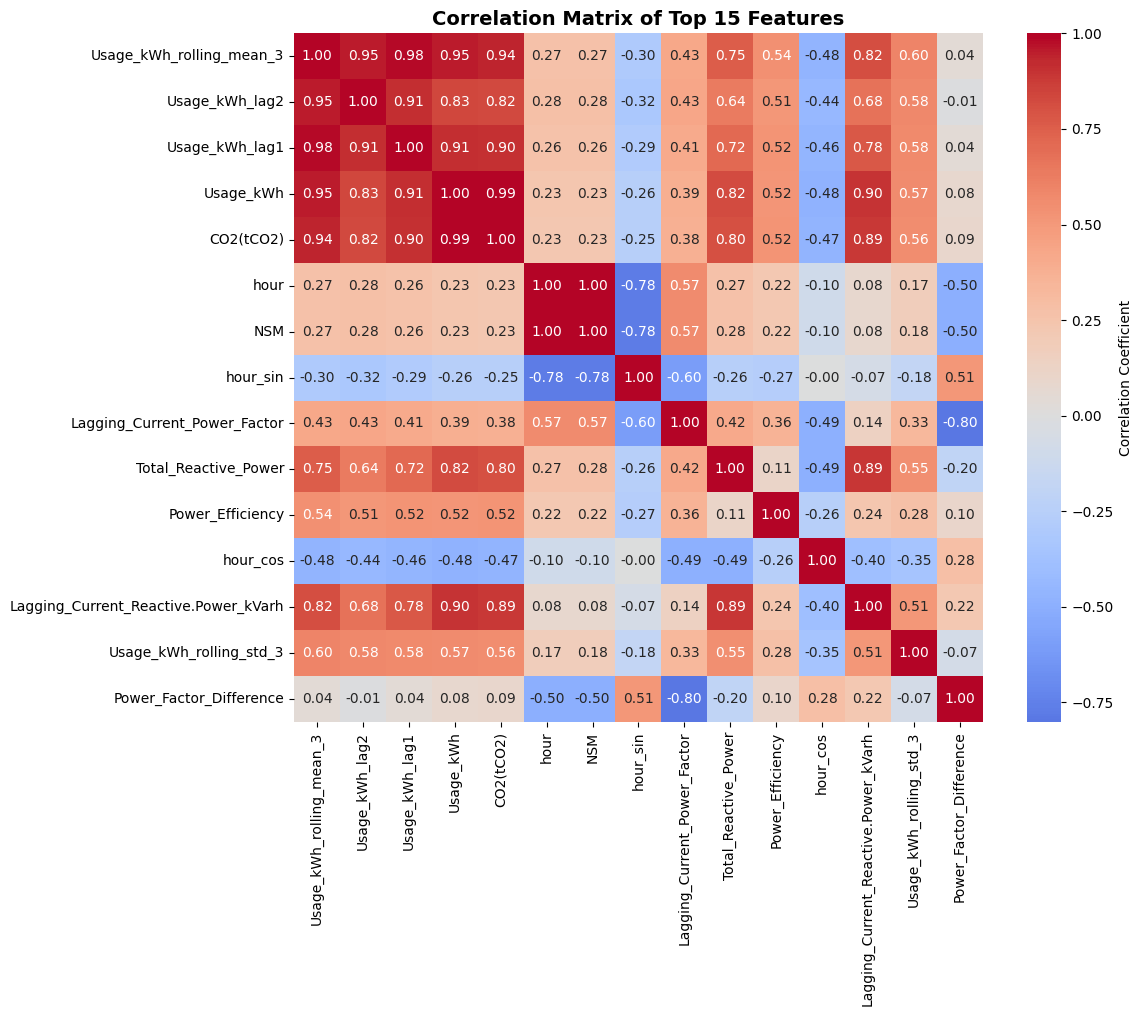


Variance Inflation Factor (VIF) for top 20 features:
                                 Feature           VIF
12  Lagging_Current_Reactive.Power_kVarh           inf
14               Power_Factor_Difference           inf
8           Lagging_Current_Power_Factor           inf
9                   Total_Reactive_Power           inf
16          Leading_Current_Power_Factor           inf
15  Leading_Current_Reactive_Power_kVarh           inf
0               Usage_kWh_rolling_mean_3  7.324286e+08
2                         Usage_kWh_lag1  8.808650e+07
1                         Usage_kWh_lag2  8.808646e+07
3                              Usage_kWh  8.808626e+07

⚠️ Features with high multicollinearity (VIF > 10): 13
['Lagging_Current_Reactive.Power_kVarh', 'Power_Factor_Difference', 'Lagging_Current_Power_Factor', 'Total_Reactive_Power', 'Leading_Current_Power_Factor']


In [11]:
# Analyze correlations and check for multicollinearity
print("=== CORRELATION ANALYSIS AND MULTICOLLINEARITY CHECK ===")

# Calculate correlation matrix
correlation_matrix = X.corr()

# Find highly correlated feature pairs
high_corr_pairs = []
threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value > threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print(f"⚠️ Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > {threshold}):")
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Show top 10
        print(f"  {feat1} - {feat2}: {corr:.3f}")
else:
    print(f"✓ No highly correlated feature pairs found (threshold: {threshold})")

# Visualize correlation matrix (for top features)
top_features_for_corr = feature_scores_f.head(15)['Feature'].tolist()
top_corr_matrix = correlation_matrix.loc[top_features_for_corr, top_features_for_corr]

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            fmt='.2f',
            square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Top 15 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Check Variance Inflation Factor (VIF) for multicollinearity
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    # Calculate VIF for top features (to avoid computational issues)
    top_20_features = feature_scores_f.head(20)['Feature'].tolist()
    X_vif = X[top_20_features]
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    print("\nVariance Inflation Factor (VIF) for top 20 features:")
    print(vif_data.head(10))
    
    high_vif_features = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
    if high_vif_features:
        print(f"\n⚠️ Features with high multicollinearity (VIF > 10): {len(high_vif_features)}")
        print(high_vif_features[:5])  # Show first 5
    else:
        print("\n✓ No severe multicollinearity detected")
        
except ImportError:
    print("\n⚠️ statsmodels not available for VIF calculation")
except Exception as e:
    print(f"\n⚠️ Error calculating VIF: {e}")

## 10. Final Data Preparation

In [12]:
# Prepare final dataset
print("=== FINAL DATA PREPARATION ===")

# Create the final transformed dataset
final_df = df_scaled.copy()

# Remove date column if present (not needed for modeling)
if 'date' in final_df.columns:
    final_df = final_df.drop(columns=['date'])
    print("✓ Date column removed")

# Ensure target variable is properly encoded
if 'Load_Type_encoded' in final_df.columns:
    # Rename for clarity
    final_df['target'] = final_df['Load_Type_encoded']
    final_df = final_df.drop(columns=['Load_Type_encoded'])
    print("✓ Target variable renamed to 'target'")

# Final dataset information
print(f"\nFinal dataset shape: {final_df.shape}")
print(f"Features: {final_df.shape[1] - 1}")
print(f"Samples: {final_df.shape[0]}")
print(f"Target classes: {final_df['target'].nunique()}")
print(f"Target distribution: {dict(final_df['target'].value_counts().sort_index())}")

# Check for any remaining issues
print(f"\nData quality check:")
print(f"Missing values: {final_df.isnull().sum().sum()}")
print(f"Infinite values: {np.isinf(final_df.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Data types: {final_df.dtypes.value_counts().to_dict()}")

if final_df.isnull().sum().sum() == 0:
    print("✅ Dataset is ready for modeling!")
else:
    print("⚠️ Dataset still has missing values - please investigate")

=== FINAL DATA PREPARATION ===
✓ Date column removed
✓ Target variable renamed to 'target'

Final dataset shape: (35040, 38)
Features: 37
Samples: 35040
Target classes: 3
Target distribution: {0: np.int64(18072), 1: np.int64(7272), 2: np.int64(9696)}

Data quality check:
Missing values: 0
Infinite values: 0
Data types: {dtype('float64'): 27, dtype('bool'): 9, dtype('O'): 1, dtype('int64'): 1}
✅ Dataset is ready for modeling!


## 11. Save Transformed Data

In [13]:
# Save the transformed data
output_filename = 'transformed_data.csv'

try:
    # Save the final transformed dataset
    final_df.to_csv(output_filename, index=False)
    print(f"✓ Transformed data successfully saved to {output_filename}")
    
    # Verify the saved file
    test_df = pd.read_csv(output_filename)
    if test_df.shape == final_df.shape:
        print("✓ File integrity verified")
    else:
        print("⚠️ File integrity check failed")
    
    # Save feature names for reference
    feature_names = [col for col in final_df.columns if col != 'target']
    joblib.dump(feature_names, 'feature_names.pkl')
    print(f"✓ Feature names saved to feature_names.pkl")
    
    # Save transformation metadata
    transformation_metadata = {
        'original_shape': df.shape,
        'final_shape': final_df.shape,
        'features_created': final_df.shape[1] - df.shape[1],
        'encoding_applied': len(categorical_features) > 0,
        'scaling_method': chosen_scaler,
        'target_classes': dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))),
        'high_correlation_pairs': len(high_corr_pairs),
        'transformation_date': datetime.now().isoformat()
    }
    
    joblib.dump(transformation_metadata, 'transformation_metadata.pkl')
    print(f"✓ Transformation metadata saved")
    
except Exception as e:
    print(f"❌ Error saving transformed data: {e}")

✓ Transformed data successfully saved to transformed_data.csv
✓ File integrity verified
✓ Feature names saved to feature_names.pkl
✓ Transformation metadata saved


## 12. Data Transformation Summary

In [14]:
# Generate comprehensive transformation summary
print("" + "="*60 + "")
print("           DATA TRANSFORMATION SUMMARY")
print("" + "="*60 + "")

print(f"📊 Dataset Transformation:")
print(f"   • Input file: {input_filename}")
print(f"   • Output file: {output_filename}")
print(f"   • Original shape: {df.shape}")
print(f"   • Final shape: {final_df.shape}")
print(f"   • Features added: {final_df.shape[1] - df.shape[1]}")

print(f"\n🔧 Transformations Applied:")
print(f"   • Feature engineering: ✅")
print(f"     - Time-based features: {len([col for col in final_df.columns if any(x in col for x in ['hour', 'month', 'day', 'year'])])}")
print(f"     - Power-related features: {len([col for col in final_df.columns if any(x in col for x in ['Total_Reactive', 'Power_Factor', 'Power_Efficiency'])])}")
print(f"     - Statistical features: {len([col for col in final_df.columns if any(x in col for x in ['lag', 'rolling'])])}")
print(f"   • Categorical encoding: {'✅' if len(categorical_features) > 0 else '➖'}")
print(f"   • Feature scaling: ✅ ({chosen_scaler})")
print(f"   • Missing value handling: ✅")

print(f"\n📈 Feature Analysis:")
print(f"   • Total features: {len(feature_names)}")
print(f"   • Numerical features: {len([col for col in final_df.columns if final_df[col].dtype in ['int64', 'float64'] and col != 'target'])}")
print(f"   • High correlation pairs: {len(high_corr_pairs)}")
print(f"   • Top feature (F-score): {feature_scores_f.iloc[0]['Feature']}")
print(f"   • Top feature (MI-score): {feature_scores_mi.iloc[0]['Feature']}")

print(f"\n🎯 Target Variable:")
print(f"   • Classes: {final_df['target'].nunique()}")
print(f"   • Distribution: {dict(final_df['target'].value_counts().sort_index())}")
print(f"   • Encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

print(f"\n💾 Saved Artifacts:")
artifacts = [
    output_filename,
    'encoders.pkl',
    f'{chosen_scaler}.pkl',
    'all_scalers.pkl',
    'feature_names.pkl',
    'transformation_metadata.pkl'
]
for artifact in artifacts:
    print(f"   • {artifact}")

print(f"\n📊 Data Quality:")
print(f"   • Missing values: {final_df.isnull().sum().sum()}")
print(f"   • Infinite values: {np.isinf(final_df.select_dtypes(include=[np.number])).sum().sum()}")
print(f"   • Data types consistency: ✅")

print(f"\n🎉 Status: {'✅ READY FOR MODEL TRAINING' if final_df.isnull().sum().sum() == 0 else '⚠️ NEEDS ATTENTION'}")

print("" + "="*60 + "")
print("Data Transformation Phase Completed Successfully!")
print(f"Timestamp: {datetime.now()}")
print("\n➡️  Next Step: Run 04_model_trainer.ipynb")
print("" + "="*60 + "")

           DATA TRANSFORMATION SUMMARY
📊 Dataset Transformation:
   • Input file: validated_data.csv
   • Output file: transformed_data.csv
   • Original shape: (35040, 16)
   • Final shape: (35040, 38)
   • Features added: 22

🔧 Transformations Applied:
   • Feature engineering: ✅
     - Time-based features: 16
     - Power-related features: 5
     - Statistical features: 4
   • Categorical encoding: ✅
   • Feature scaling: ✅ (standard_scaler)
   • Missing value handling: ✅

📈 Feature Analysis:
   • Total features: 37
   • Numerical features: 27
   • High correlation pairs: 27
   • Top feature (F-score): Usage_kWh_rolling_mean_3
   • Top feature (MI-score): NSM

🎯 Target Variable:
   • Classes: 3
   • Distribution: {0: np.int64(18072), 1: np.int64(7272), 2: np.int64(9696)}
   • Encoding: {'Light_Load': np.int64(0), 'Maximum_Load': np.int64(1), 'Medium_Load': np.int64(2)}

💾 Saved Artifacts:
   • transformed_data.csv
   • encoders.pkl
   • standard_scaler.pkl
   • all_scalers.pkl
   • 